In [1]:
batch_size = 64
train_lr = 1e-3
fine_tune_lr = 1e-4

## Data loading

In [2]:
import cv2
import numpy as np
import torch
import torchvision
from pathlib import Path
import os

torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
normalize = torchvision.transforms.Normalize(mean.tolist(), std.tolist()) 
unnormalize = torchvision.transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.RandomRotation(degrees=30),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.ToTensor(),
        normalize
    ]),
    'val': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        normalize
    ]),
    'test': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        normalize
    ])
}

data_dir = '/kaggle/input/french-birds/fr_birds_dataset/'

is_valid_file = lambda x: not 'PaxHeader' in x and not '_' in x.split('/')[-1] # and int(''.join(x.split('/')[-1].split('.')[:-1])) < 50
image_datasets = {x: torchvision.datasets.ImageFolder(str(Path(data_dir) / x), data_transforms[x], is_valid_file=is_valid_file)
                  for x in ['train', 'val', 'test']}
datasets_len = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                    batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
              for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

In [5]:
from sklearn.utils.class_weight import compute_class_weight

targets = image_datasets['train'].targets
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [6]:
import matplotlib.pyplot as plt

def display_image_grid(images, titles, cols, figsize=(20, 10), fig_layout_pad=2.0):
    assert len(images) % cols == 0

    rows = len(images) // cols
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    fig.tight_layout(pad=fig_layout_pad)
    for i in range(rows):
        for j in range(cols):
            idx = j + i * cols
            axes[i, j].axis('off')
            title = titles[idx]
            color = 'black' if len(title) == 1 else title[1]
            axes[i, j].set_title(titles[idx][0], color=color)
            axes[i, j].imshow(images[idx])
    fig.show()

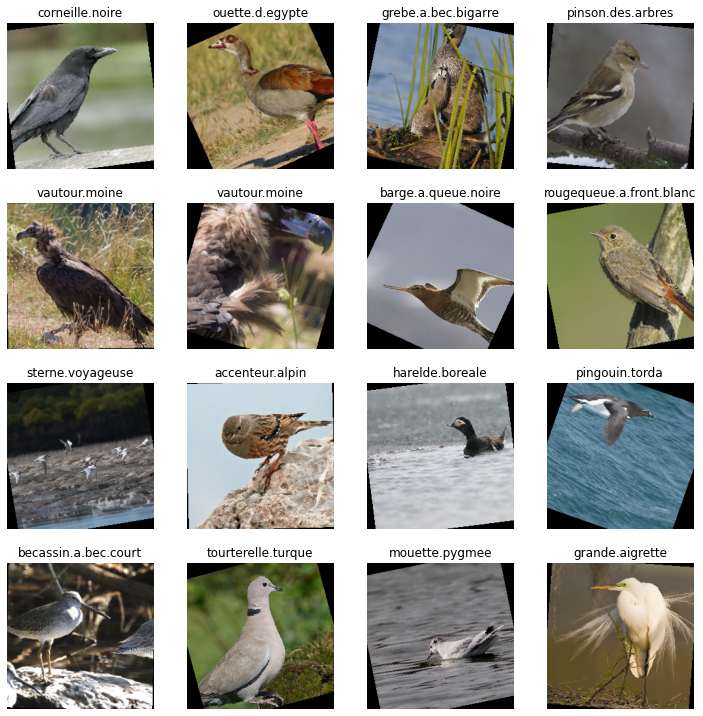

In [7]:
inputs, labels = next(iter(dataloaders['train']))
inputs = unnormalize(inputs)
inputs, labels = inputs[:16], labels[:16]
inputs = inputs.permute(0, 2, 3, 1)
titles = [[class_names[label]] for label in labels]

display_image_grid(inputs, titles, cols=4, fig_layout_pad=0, figsize=(10, 10))

## Model

In [8]:
model = torchvision.models.efficientnet_b0(pretrained=True)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

nb_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(nb_features, 2048),
    torch.nn.SiLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(2048, len(class_names))
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

## Transfer learning

In [9]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights, reduction='mean', label_smoothing=0.1)
criterion.to(device)

CrossEntropyLoss()

In [10]:
params_to_update = []
for param in model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
optimizer = torch.optim.AdamW(params_to_update, lr=train_lr)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [11]:
import copy
from tqdm.notebook import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, restore=True):
    saved_epoch, saved_model, saved_optimizer = 0, None, None
    if restore and os.path.exists('best_model.pth'):
        ckpt = torch.load('best_model.pth', map_location=device)
        saved_epoch = ckpt['epoch'] + 1
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])

    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    hist = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(max(0, saved_epoch), num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=f'Running {phase} phase', total=len(dataloaders[phase])):
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # argmax
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / datasets_len[phase]
            epoch_acc = running_corrects / datasets_len[phase]
            hist[f'{phase}_loss'].append(epoch_loss)
            hist[f'{phase}_acc'].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())

                torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'loss': criterion,
                    },
                    'best_model.pth'
                )

        print()

    # load best model weights
    model.load_state_dict(best_weights)
    return model, hist

In [12]:
model, hist = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 4.6215 Acc: 0.1632


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 3.6028 Acc: 0.3338

Epoch 1/9
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 3.3464 Acc: 0.3934


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 3.3232 Acc: 0.4039

Epoch 2/9
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 2.9054 Acc: 0.5006


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 3.2419 Acc: 0.4263

Epoch 3/9
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 2.4644 Acc: 0.6321


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 3.1067 Acc: 0.4683

Epoch 4/9
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 2.2977 Acc: 0.6804


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 3.0789 Acc: 0.4718

Epoch 5/9
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 2.1836 Acc: 0.7168


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 3.0890 Acc: 0.4839

Epoch 6/9
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 2.0024 Acc: 0.7811


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 3.0409 Acc: 0.4933

Epoch 7/9
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.9400 Acc: 0.8007


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 3.0474 Acc: 0.4920

Epoch 8/9
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.8952 Acc: 0.8125


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 3.0058 Acc: 0.4960

Epoch 9/9
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.8199 Acc: 0.8414


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 3.0007 Acc: 0.5058



## Fine tuning

In [13]:
# Unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=fine_tune_lr)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

In [15]:
model, fine_tune_hist = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25, restore=False)
for key in hist.keys():
    hist[key].extend(fine_tune_hist[key])

Epoch 0/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.6368 Acc: 0.8907


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.6417 Acc: 0.5952

Epoch 1/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.4720 Acc: 0.9427


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.5527 Acc: 0.6157

Epoch 2/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.3869 Acc: 0.9658


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.5047 Acc: 0.6314

Epoch 3/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.3248 Acc: 0.9782


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.4779 Acc: 0.6390

Epoch 4/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.2976 Acc: 0.9840


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.4501 Acc: 0.6439

Epoch 5/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.2655 Acc: 0.9901


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.4428 Acc: 0.6600

Epoch 6/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.2433 Acc: 0.9910


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.4174 Acc: 0.6591

Epoch 7/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.2256 Acc: 0.9948


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3985 Acc: 0.6689

Epoch 8/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.2107 Acc: 0.9963


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3967 Acc: 0.6685

Epoch 9/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1967 Acc: 0.9971


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.4056 Acc: 0.6667

Epoch 10/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1869 Acc: 0.9974


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3982 Acc: 0.6752

Epoch 11/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1767 Acc: 0.9975


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3916 Acc: 0.6658

Epoch 12/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1670 Acc: 0.9982


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3747 Acc: 0.6765

Epoch 13/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1586 Acc: 0.9987


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3826 Acc: 0.6743

Epoch 14/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1534 Acc: 0.9987


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3741 Acc: 0.6801

Epoch 15/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1493 Acc: 0.9986


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3700 Acc: 0.6801

Epoch 16/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1445 Acc: 0.9987


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3666 Acc: 0.6805

Epoch 17/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1398 Acc: 0.9990


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3739 Acc: 0.6863

Epoch 18/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1342 Acc: 0.9991


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3771 Acc: 0.6805

Epoch 19/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1301 Acc: 0.9993


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3689 Acc: 0.6814

Epoch 20/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1270 Acc: 0.9991


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3639 Acc: 0.6859

Epoch 21/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1242 Acc: 0.9995


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3709 Acc: 0.6787

Epoch 22/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1201 Acc: 0.9995


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3662 Acc: 0.6823

Epoch 23/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1171 Acc: 0.9995


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3578 Acc: 0.6814

Epoch 24/24
----------


Running train phase:   0%|          | 0/293 [00:00<?, ?it/s]

train Loss: 1.1138 Acc: 0.9997


Running val phase:   0%|          | 0/35 [00:00<?, ?it/s]

val Loss: 2.3673 Acc: 0.6850



## Evaluation

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k)
    return res

@torch.no_grad()
def evaluate(model):
    model.eval()
    
    test_preds, test_labels = [], []
    running_corrects_top1, running_corrects_top3 = 0, 0
    for inputs, labels in tqdm(dataloaders['test'], desc=f'Evaluation', total=len(dataloaders['test'])):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        
        acc_top1, acc_top3 = accuracy(outputs, labels, topk=(1, 3))
        running_corrects_top1 += acc_top1
        running_corrects_top3 += acc_top3

    test_acc_top1 = running_corrects_top1.double() / datasets_len['test']
    print(f'Test TOP 1 accurary: {test_acc_top1}')
    
    test_acc_top3 = running_corrects_top3.double() / datasets_len['test']
    print(f'Test TOP 3 accurary: {test_acc_top3}')
    
#     arr = confusion_matrix(test_labels, test_preds)
#     df_cm = pd.DataFrame(arr, class_names, class_names)
#     plt.figure(figsize = (9,6))
#     sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
#     plt.xlabel("prediction")
#     plt.ylabel("label (ground truth)")
#     plt.show()

In [17]:
evaluate(model)

Evaluation:   0%|          | 0/48 [00:00<?, ?it/s]

Test TOP 1 accurary: 0.6663395485770364
Test TOP 3 accurary: 0.8007850834151129


In [18]:
def plot_hist(hist):
    x = np.arange(len(hist['train_loss']))

    plt.plot(x, hist['train_loss'], label='train loss')
    plt.plot(x, hist['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.plot(x, hist['train_acc'], label='train acc')
    plt.plot(x, hist['val_acc'], label='val acc')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

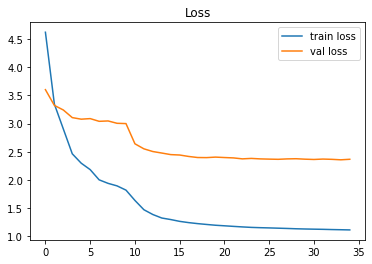

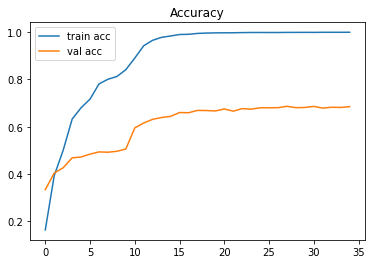

In [19]:
plot_hist(hist)

In [20]:
@torch.no_grad()
def show_predictions(model, n, cols=5, figsize=(20, 10)):
    assert n % cols == 0

    model.eval()

    inputs, preds, labels = [], [], []
    while len(inputs) < n:
        x, y = next(iter(dataloaders['test']))
        x, y = x.to(device), y.to(device)

        z = model(x)
        _, z = torch.max(z, 1) # argmax

        preds.extend(z.cpu().numpy())
        inputs.extend(unnormalize(x).cpu().numpy())
        labels.extend(y.cpu().numpy())

    # Keep first n images
    inputs = np.array(inputs)[:n]
    inputs = inputs.transpose(0, 2, 3, 1)
    preds = np.array(preds)[:n]
    labels = np.array(labels)[:n]

    # Diplay image grid
    titles = []
    for i in range(len(inputs)):
        if preds[i] == labels[i]:
            titles.append([f'Pred: {class_names[preds[i]]}', 'green'])
        else:
            titles.append([f'Pred: {class_names[preds[i]]}\nExp: {class_names[labels[i]]}', 'red'])
    display_image_grid(inputs, titles, cols, figsize)

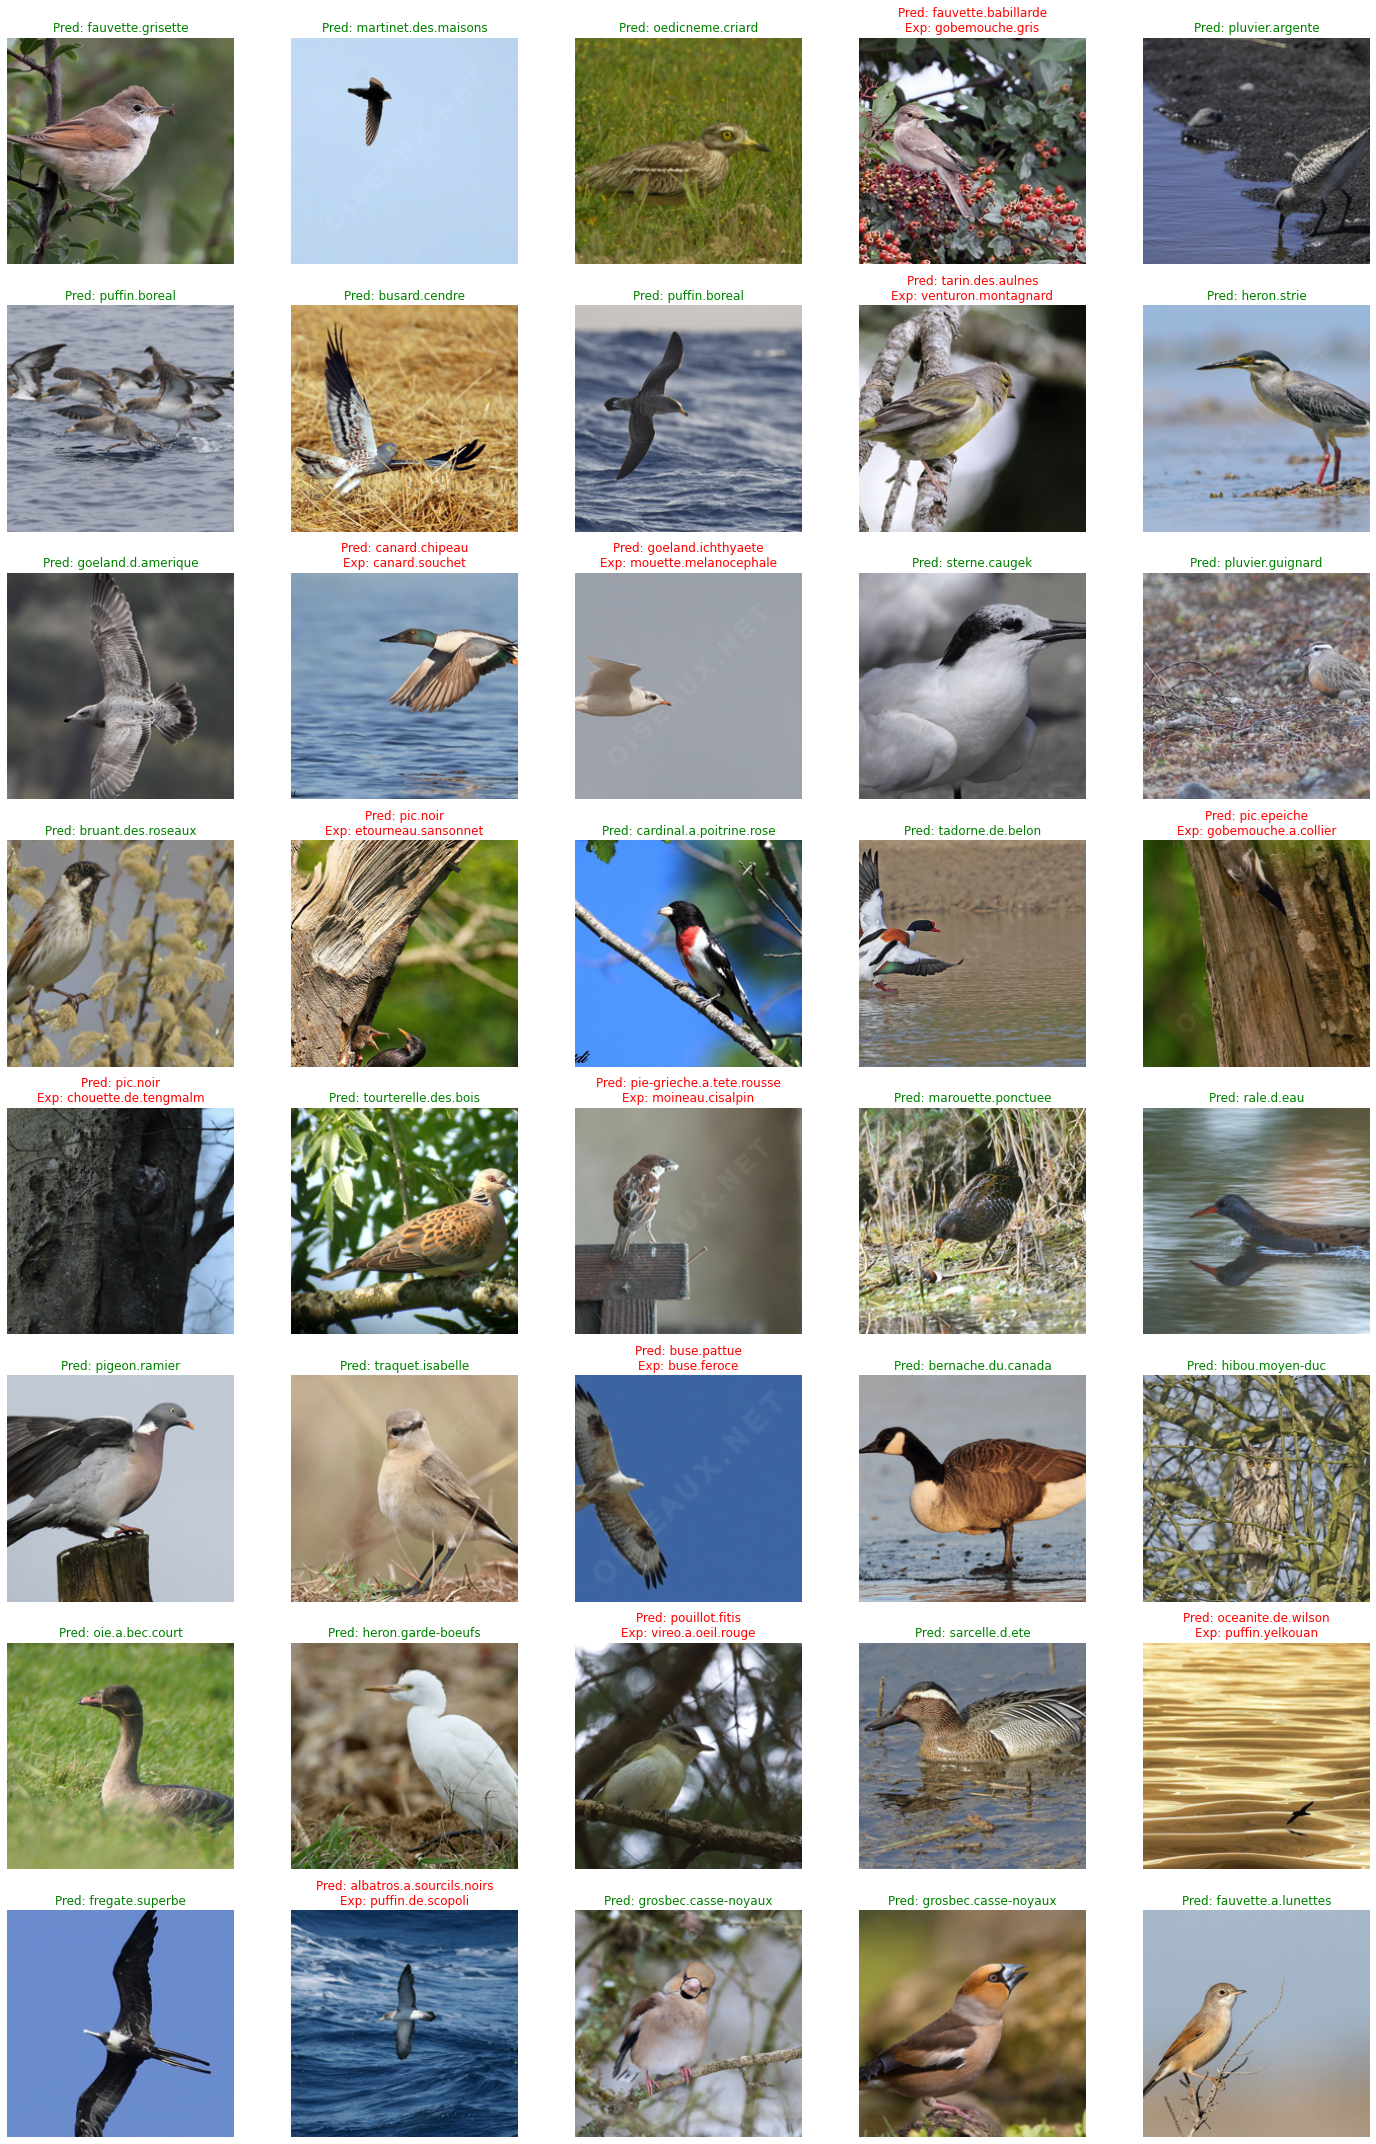

In [21]:
show_predictions(model, 40, figsize=(20, 30))